Wilcoxon Test Results:
Random Forest vs Gradient Boosted: Statistic=9.0, p-value=6.146728992462158e-08
Random Forest vs Linear Regression: Statistic=0.0, p-value=1.862645149230957e-09
Gradient Boosted vs Linear Regression: Statistic=0.0, p-value=1.862645149230957e-09


<Figure size 1000x600 with 0 Axes>

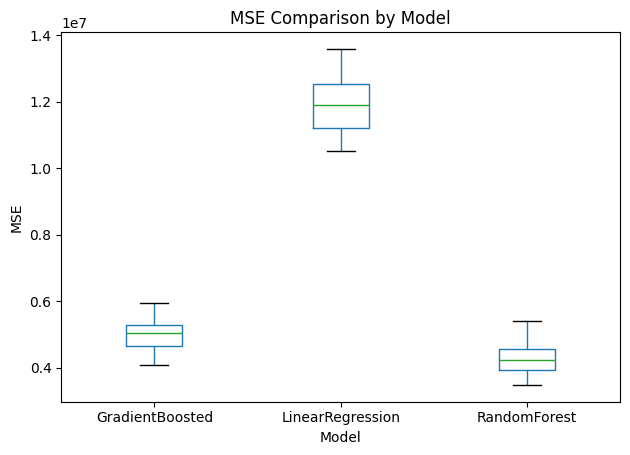

<Figure size 1000x600 with 0 Axes>

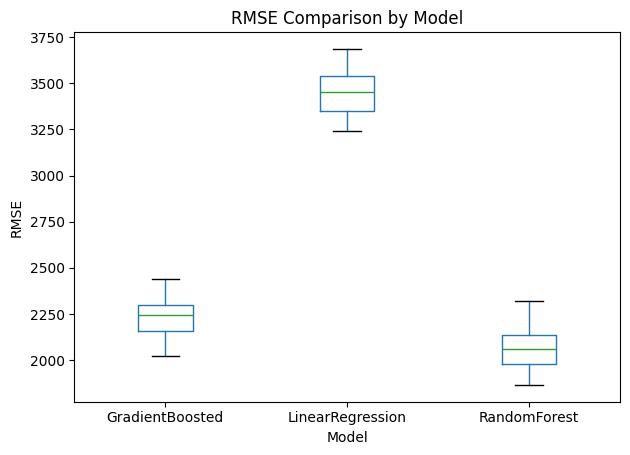

<Figure size 1000x600 with 0 Axes>

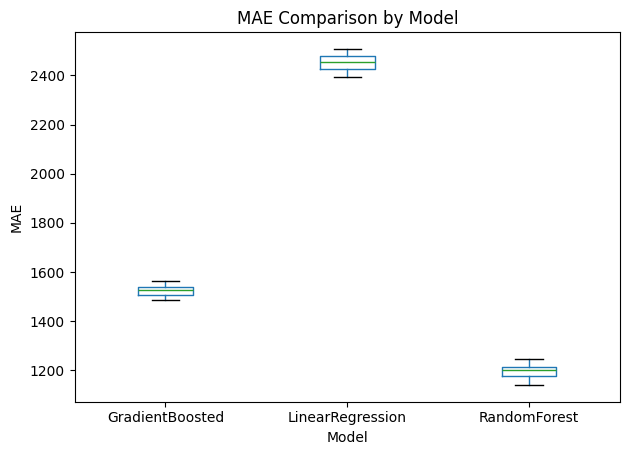

<Figure size 1000x600 with 0 Axes>

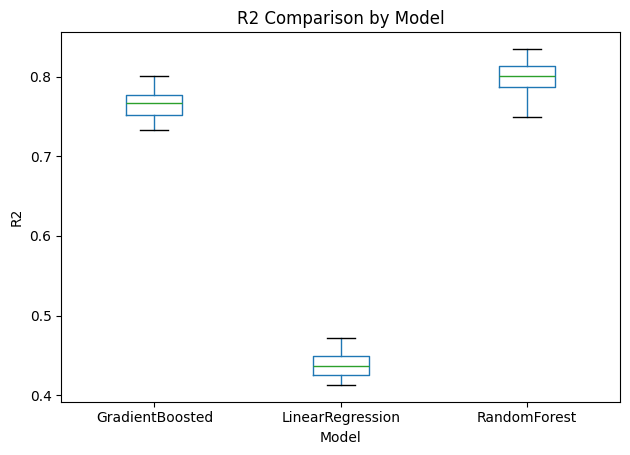

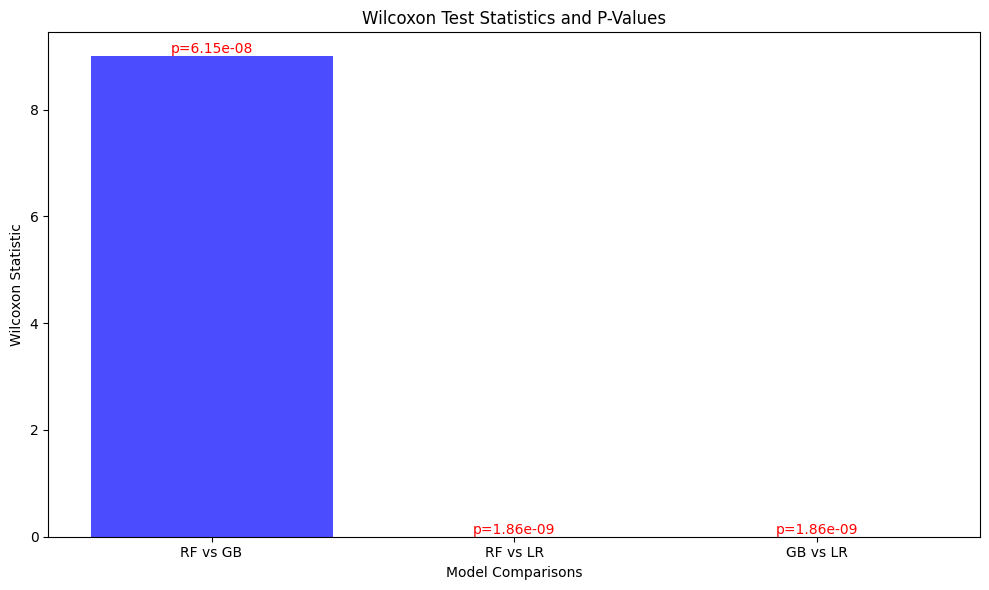

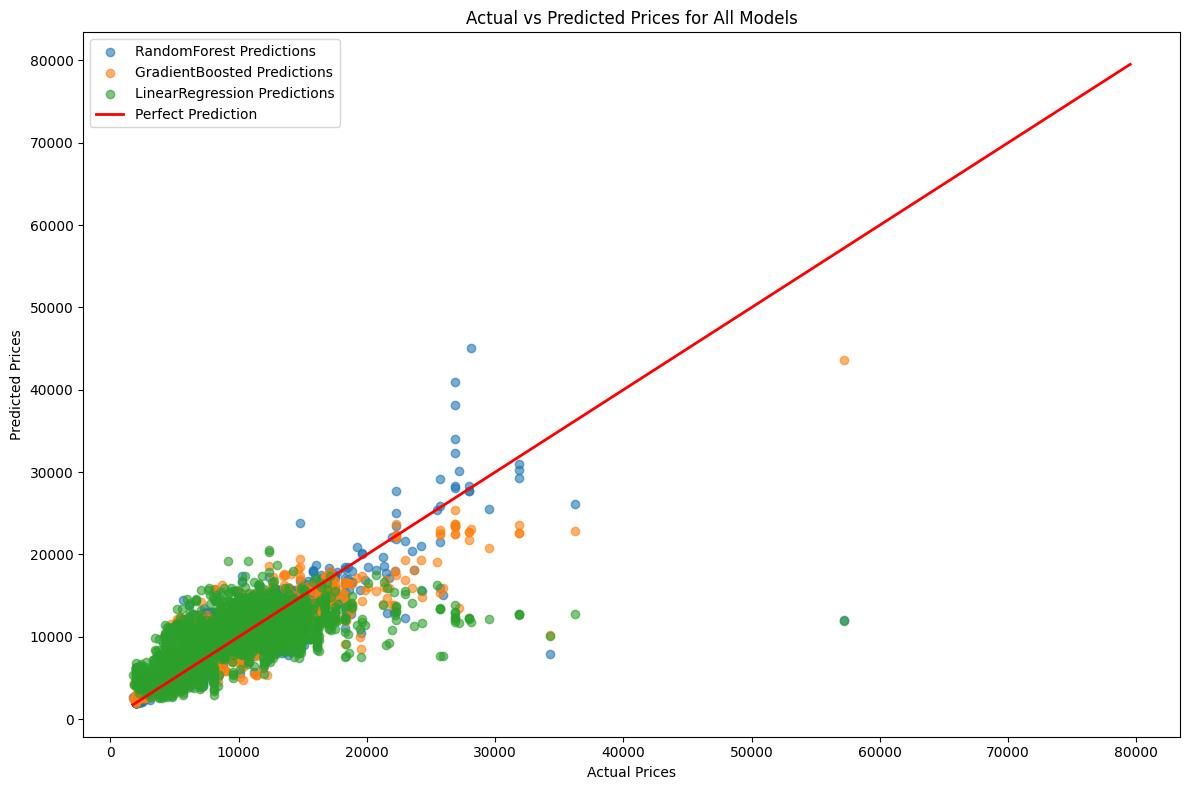

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Load dataset
data_path = '/content/flight_dataset.csv'
df = pd.read_csv(data_path)

# Preprocess the data
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target variable
X = df.drop(columns=['Price'])
y = df['Price']

# Metrics storage
metrics = {
    "Model": [],
    "Iteration": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "R2": []
}

# Define models
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosted": GradientBoostingRegressor(random_state=42),
    "LinearRegression": LinearRegression()
}

# Run models with random subsampling
n_runs = 30
for run in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)

    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store metrics
        metrics["Model"].append(model_name)
        metrics["Iteration"].append(run + 1)
        metrics["MSE"].append(mse)
        metrics["RMSE"].append(rmse)
        metrics["MAE"].append(mae)
        metrics["R2"].append(r2)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics for analysis
metrics_df.to_csv('/content/model_metrics.csv', index=False)

# Wilcoxon test comparisons
rf_mse = metrics_df[metrics_df['Model'] == 'RandomForest']['MSE']
gb_mse = metrics_df[metrics_df['Model'] == 'GradientBoosted']['MSE']
lr_mse = metrics_df[metrics_df['Model'] == 'LinearRegression']['MSE']

stat_rf_gb, p_rf_gb = wilcoxon(rf_mse, gb_mse)
stat_rf_lr, p_rf_lr = wilcoxon(rf_mse, lr_mse)
stat_gb_lr, p_gb_lr = wilcoxon(gb_mse, lr_mse)

# Display Wilcoxon test results
print("Wilcoxon Test Results:")
print(f"Random Forest vs Gradient Boosted: Statistic={stat_rf_gb}, p-value={p_rf_gb}")
print(f"Random Forest vs Linear Regression: Statistic={stat_rf_lr}, p-value={p_rf_lr}")
print(f"Gradient Boosted vs Linear Regression: Statistic={stat_gb_lr}, p-value={p_gb_lr}")

# Plot boxplots for metrics
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    plt.figure(figsize=(10, 6))
    metrics_df.boxplot(column=metric, by='Model', grid=False)
    plt.title(f'{metric} Comparison by Model')
    plt.suptitle('')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


# Bar chart for Wilcoxon test results
comparisons = [
    ("RF vs GB", stat_rf_gb, p_rf_gb),
    ("RF vs LR", stat_rf_lr, p_rf_lr),
    ("GB vs LR", stat_gb_lr, p_gb_lr)
]

comparison_labels = [comp[0] for comp in comparisons]
statistics = [comp[1] for comp in comparisons]
p_values = [comp[2] for comp in comparisons]

# Plot the Wilcoxon results
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_labels, statistics, color='blue', alpha=0.7, label='Wilcoxon Statistic')
plt.xlabel("Model Comparisons")
plt.ylabel("Wilcoxon Statistic")
plt.title("Wilcoxon Test Statistics and P-Values")

# Annotate p-values above bars
for bar, p_value in zip(bars, p_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"p={p_value:.3g}",
             ha='center', va='bottom', fontsize=10, color='red')

plt.tight_layout()
plt.show()


# Train and predict for all models
predictions = {}
for model_name, model in models.items():
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Predict prices
    y_pred = model.predict(X_test)

    # Store predictions and true values
    predictions[model_name] = (y_test, y_pred)

# Plot actual vs predicted prices for all models
plt.figure(figsize=(12, 8))
for model_name, (y_actual, y_pred) in predictions.items():
    plt.scatter(
        y_actual, y_pred, alpha=0.6, label=f'{model_name} Predictions'
    )

# Plot the perfect prediction line
plt.plot(
    [min(y), max(y)], [min(y), max(y)], color='red', linewidth=2, label='Perfect Prediction'
)

# Add labels and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices for All Models")
plt.legend()
plt.tight_layout()
plt.show()
